In [75]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import sys

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pandas as pd
import statsmodels.api as sm

In [76]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train_data.head()

,id,datetime,count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [77]:
train_data.shape

(18288, 3)

In [78]:
train_data.isnull().sum()

id          0
datetime    0
count       0
dtype: int64

In [79]:
test_data.isnull().sum()

id          0
datetime    0
dtype: int64

In [80]:
train_data.dtypes

id           int64
datetime    object
count        int64
dtype: object

In [81]:
train_data.nunique()

id          18288
datetime    18288
count         437
dtype: int64

In [82]:
train = train_data[0:11855]
test = train_data[11855:]

In [83]:
train.head()

,id,datetime,count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [86]:
train_data.datetime = pd.to_datetime(train_data.datetime,format = '%d-%m-%Y %H:%M')
train_data_idx = pd.period_range(min(train_data.datetime), max(train_data.datetime))
train_data.reindex(train_data_idx, fill_value = 0)

,id,datetime,count
2012-08-25,0,0,0
2012-08-26,0,0,0
2012-08-27,0,0,0
2012-08-28,0,0,0
2012-08-29,0,0,0
...,...,...,...
2014-09-21,0,0,0
2014-09-22,0,0,0
2014-09-23,0,0,0
2014-09-24,0,0,0


In [54]:
#Aggregating the dataset at daily level
train_data.Timestamp = pd.to_datetime(train_data.datetime, format = '%d-%m-%Y %H:%M')
train_data.index = train_data.Timestamp 
train_data = train_data.resample('D').mean()
train.datetime = pd.to_datetime(train.datetime,format = '%d-%m-%Y %H:%M')
train_idx = pd.period_range(min(train.datetime), max(train.datetime))
train.reindex(train_idx, fill_value = 0)
train.Timestamp = pd.to_datetime(train.datetime,format = '%d-%m-%Y %H:%M')
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.datetime = pd.to_datetime(test.datetime,format = '%d-%m-%Y %H:%M')
test_idx = pd.period_range(min(test.datetime), max(test.datetime))
test.reindex(test_idx, fill_value = 0)
test.Timestamp = pd.to_datetime(test.datetime,format='%d-%m-%Y %H:%M')
test.index = test.Timestamp 
test = test.resample('D').mean()

C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


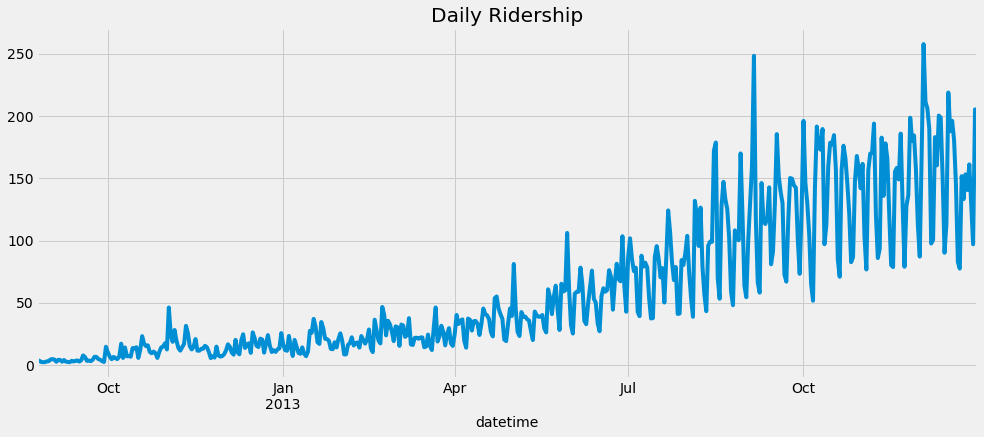

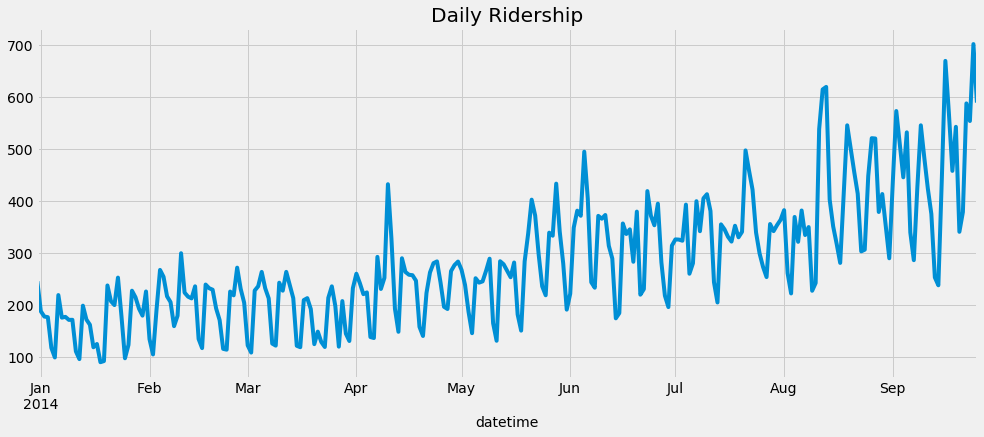

In [55]:
#Plotting data
train['count'].plot(figsize = (15, 6), title = 'Daily Ridership', fontsize = 14)
plt.show()
test['count'].plot(figsize = (15, 6), title = 'Daily Ridership', fontsize = 14)
plt.show()

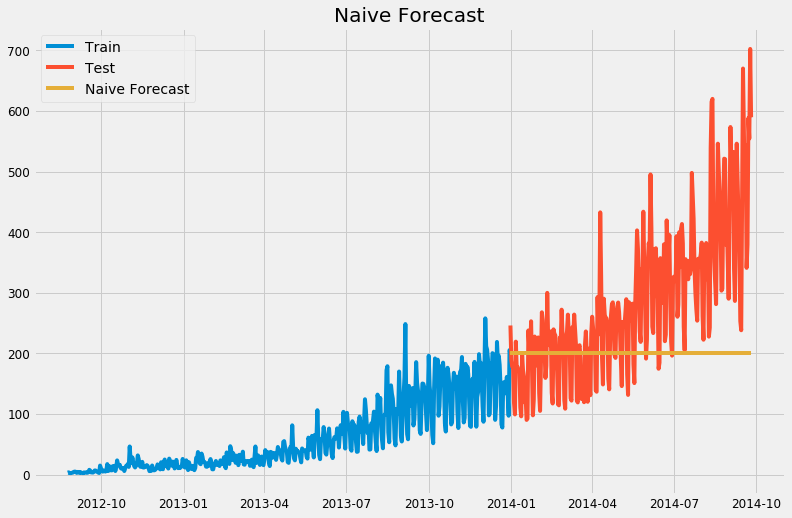

145.2067587281829

In [56]:
dd = np.asarray(train['count'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize = (12, 8))
plt.plot(train.index, train['count'], label = 'Train')
plt.plot(test.index, test['count'], label = 'Test')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend(loc = 'best')
plt.title("Naive Forecast")
plt.show()
sqrt(mean_squared_error(test['count'], y_hat.naive))

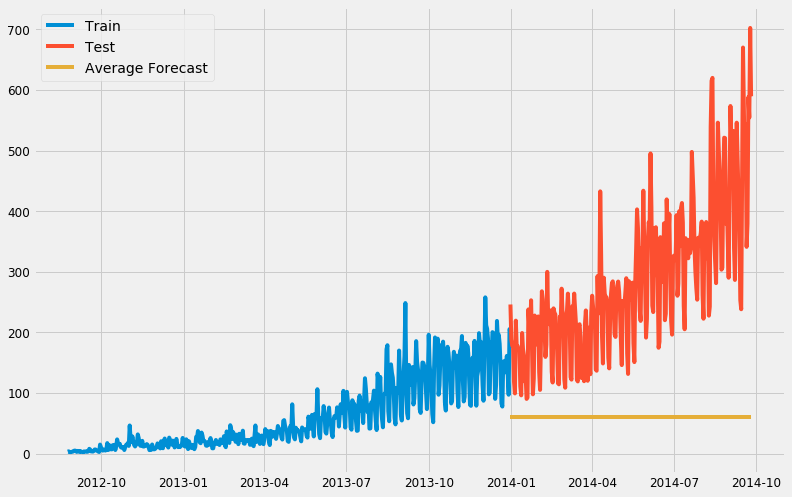

252.2606829052643

In [57]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['count'].mean()
plt.figure(figsize = (12,8))
plt.plot(train['count'], label = 'Train')
plt.plot(test['count'], label = 'Test')
plt.plot(y_hat_avg['avg_forecast'], label = 'Average Forecast')
plt.legend(loc = 'best')
plt.show()
sqrt(mean_squared_error(test['count'], y_hat_avg.avg_forecast))

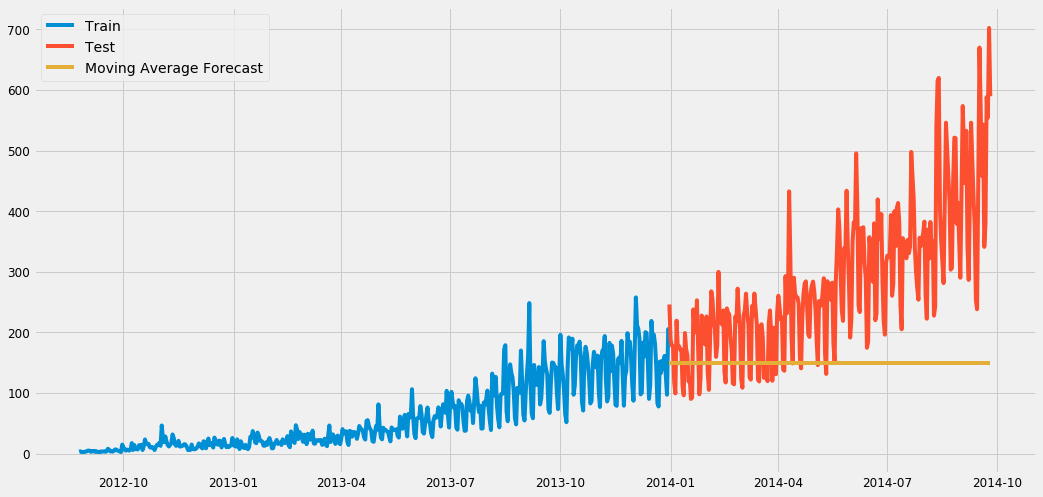

179.48701330450993

In [58]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['count'].rolling(60).mean().iloc[-1]
plt.figure(figsize = (16,8))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label = 'Moving Average Forecast')
plt.legend(loc = 'best')
plt.show()
sqrt(mean_squared_error(test['count'], y_hat_avg.moving_avg_forecast))

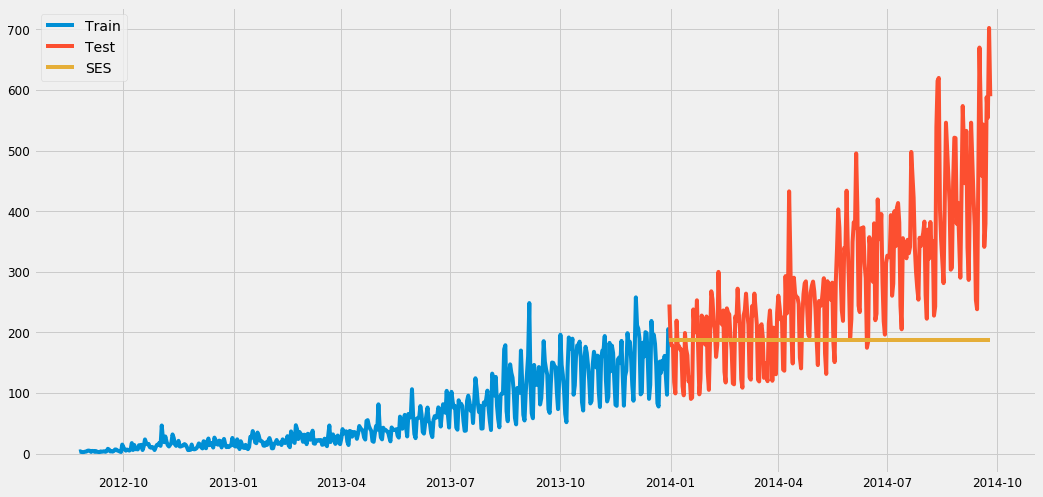

152.80969647981885

In [59]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['count'])).fit(smoothing_level = 0.6,optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize = (16,8))
plt.plot(train['count'], label = 'Train')
plt.plot(test['count'], label = 'Test')
plt.plot(y_hat_avg['SES'], label = 'SES')
plt.legend(loc = 'best')
plt.show()
sqrt(mean_squared_error(test['count'], y_hat_avg.SES))

TypeError: float() argument must be a string or a number, not 'method'

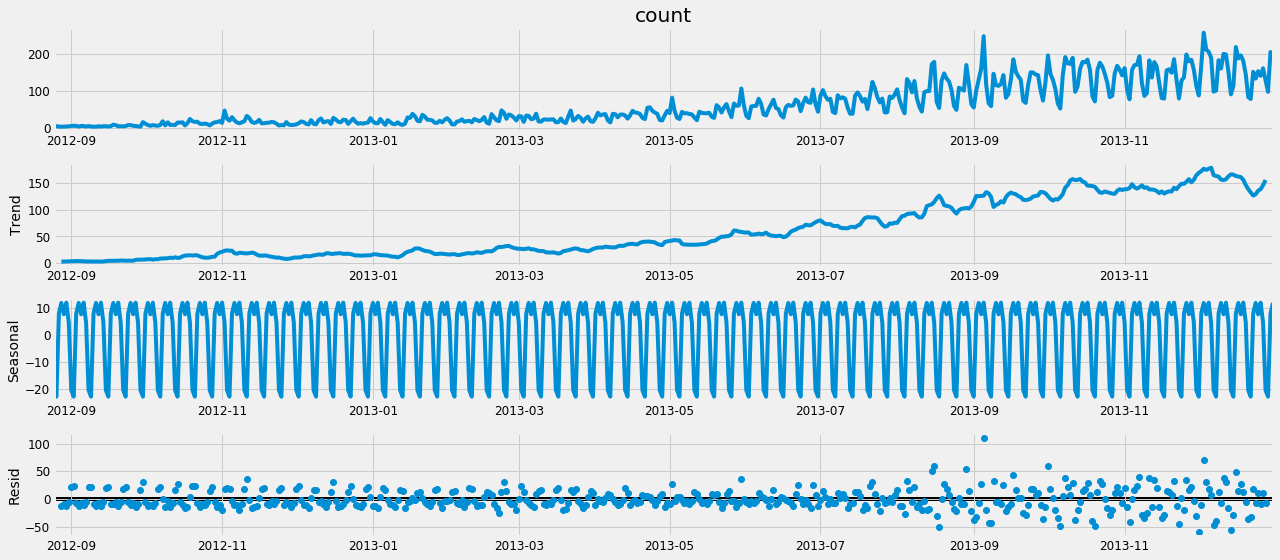

In [60]:
sm.tsa.seasonal_decompose(train['count']).plot()
result = sm.tsa.stattools.adfuller(train.count)
plt.show()

C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


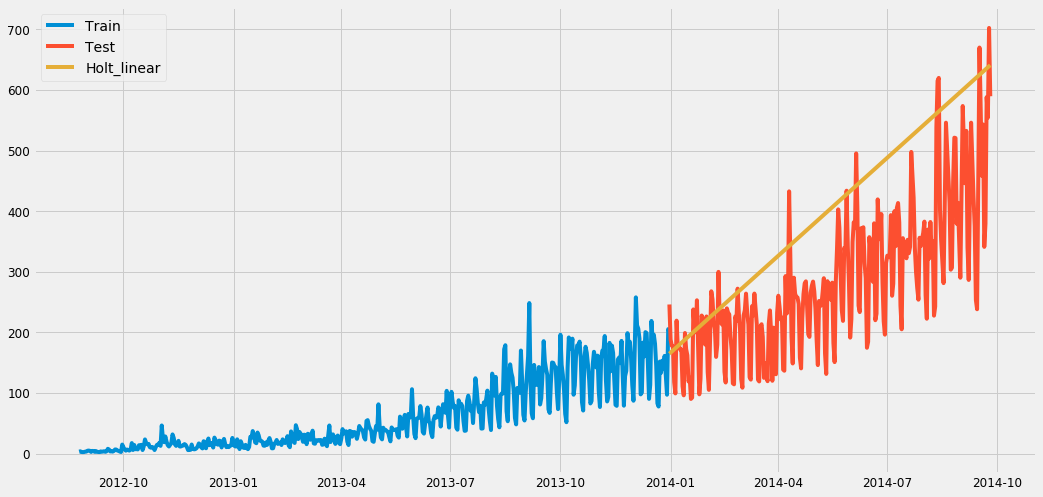

150.56409639977184

In [61]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize = (16,8))
plt.plot(train['count'], label = 'Train')
plt.plot(test['count'], label = 'Test')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_linear')
plt.legend(loc = 'best')
plt.show()
sqrt(mean_squared_error(test['count'], y_hat_avg.Holt_linear))

C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\ProgramData\Anaconda3\envs\deepai\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


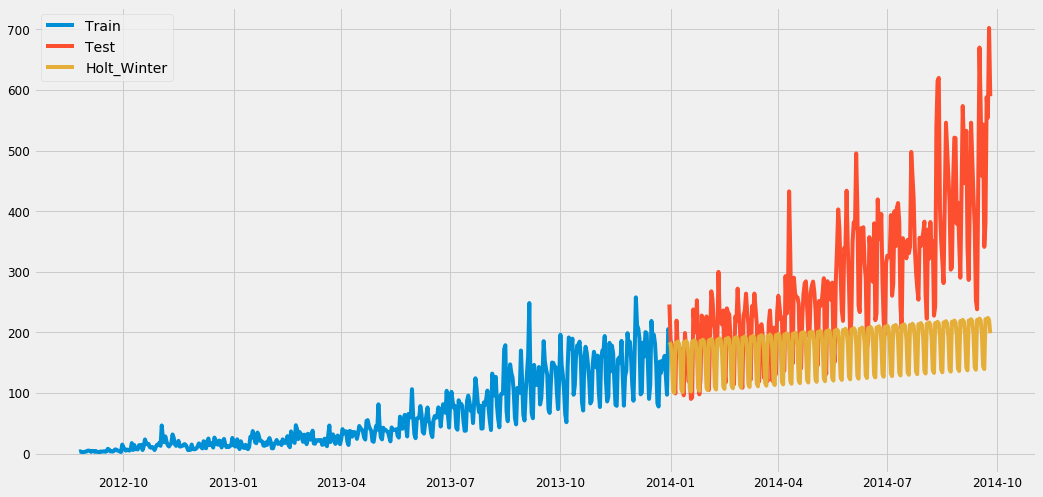

153.17649828891354

In [62]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['count']) ,seasonal_periods = 7 ,trend = 'add', seasonal = 'add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize = (16,8))
plt.plot( train['count'], label = 'Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt_Winter')
plt.legend(loc = 'best')
plt.show()
sqrt(mean_squared_error(test['count'], y_hat_avg.Holt_Winter))

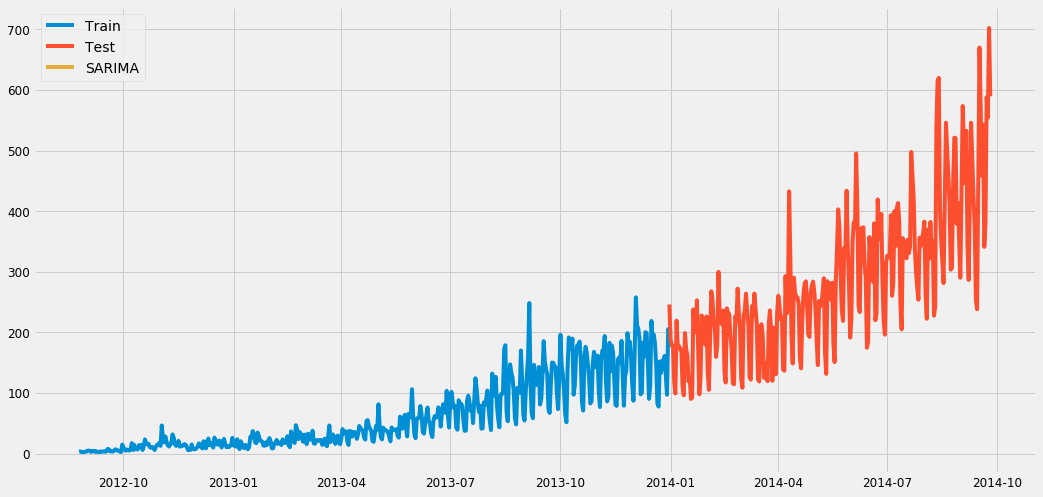

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [63]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train['count'], order = (2, 1, 4), seasonal_order = (0, 1, 1, 7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start = "2013-11-1", end = "2013-12-31", dynamic = True)
plt.figure(figsize = (16,8))
plt.plot( train['count'], label = 'Train')
plt.plot(test['count'], label = 'Test')
plt.plot(y_hat_avg['SARIMA'], label = 'SARIMA')
plt.legend(loc = 'best')
plt.show()
sqrt(mean_squared_error(test['count'], y_hat_avg.SARIMA))